In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install lime
#!pip install shap
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def dispersal(weights, features):
    feat_len = len(features)
    #print(feat_len)
    weights_by_feat = []
       
    for i in list(range(feat_len)):
        feat_weight = []
        for iteration in weights:
            feat_weight.append(iteration[i])
        weights_by_feat.append(feat_weight)
        
    #for iteration in weights:
     #   for val in iteration:
      #      idx = iteration.index(val)
       #     print(idx)
        #    weights_by_feat[idx].append(val)
    
    dispersal = []
    dispersal_no_outlier = []
    
    for each in weights_by_feat:
        #print("Feature", weights_by_feat.index(each)+1)
        mean = np.mean(each)
        std_dev = np.std(each)
        var = std_dev**2
        
        if mean == 0:
            dispersal.append(0)
            dispersal_no_outlier.append(0)
        #print(each)
        else:
            #dispersal with outliers
            rel_var = var/abs(mean)
            dispersal.append(rel_var)
            
            #dispersal without outliers - remove anything with a z-score higher
            #than 3 (more than 3 standard deviations away from the mean)
            rem_outlier = []
            z_scores = stats.zscore(each)
            #print(z_scores)
            #print("New list:")
            for i in range(len(z_scores)):
                #print(each[i],":",z_scores[i])
                if -3 < z_scores[i] < 3:
                    rem_outlier.append(each[i])
                #print(rem_outlier)
            if rem_outlier != []:
                new_mean = np.mean(rem_outlier)
                if new_mean == 0:
                    dispersal_no_outlier.append(0)
                else:
                    new_std = np.std(rem_outlier)
                    new_var = new_std**2
                    new_rel_var = new_var/abs(new_mean)
                    dispersal_no_outlier.append(new_rel_var)
            else:
                dispersal_no_outlier.append(rel_var)
    #print(dispersal_no_outlier)
    return dispersal, dispersal_no_outlier

In [9]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "single"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
max_feat = 9999999999999999999999999999999

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['bpic2012_accepted']

Bucket 1
Category 1 of 2. Instance 1 of 400
Category 1 of 2. Instance 2 of 400
Category 1 of 2. Instance 3 of 400
Category 1 of 2. Instance 4 of 400
Category 1 of 2. Instance 5 of 400
Category 1 of 2. Instance 6 of 400
Category 1 of 2. Instance 7 of 400
Category 1 of 2. Instance 8 of 400
Category 1 of 2. Instance 9 of 400
Category 1 of 2. Instance 10 of 400
Category 1 of 2. Instance 11 of 400
Category 1 of 2. Instance 12 of 400
Category 1 of 2. Instance 13 of 400
Category 1 of 2. Instance 14 of 400
Category 1 of 2. Instance 15 of 400
Category 1 of 2. Instance 16 of 400
Category 1 of 2. Instance 17 of 400
Category 1 of 2. Instance 18 of 400
Category 1 of 2. Instance 19 of 400
Category 1 of 2. Instance 20 of 400
Category 1 of 2. Instance 21 of 400
Category 1 of 2. Instance 22 of 400
Category 1 of 2. Instance 23 of 400
Category 1 of 2. Instance 24 of 400
Category 1 of 2. Instance 25 of 400
Category 1 of 2. Instance 26 of 400
Category 1 of 2. Instance 27 of 400
Category 1 of 2. Instance 28

Category 1 of 2. Instance 226 of 400
Category 1 of 2. Instance 227 of 400
Category 1 of 2. Instance 228 of 400
Category 1 of 2. Instance 229 of 400
Category 1 of 2. Instance 230 of 400
Category 1 of 2. Instance 231 of 400
Category 1 of 2. Instance 232 of 400
Category 1 of 2. Instance 233 of 400
Category 1 of 2. Instance 234 of 400
Category 1 of 2. Instance 235 of 400
Category 1 of 2. Instance 236 of 400
Category 1 of 2. Instance 237 of 400
Category 1 of 2. Instance 238 of 400
Category 1 of 2. Instance 239 of 400
Category 1 of 2. Instance 240 of 400
Category 1 of 2. Instance 241 of 400
Category 1 of 2. Instance 242 of 400
Category 1 of 2. Instance 243 of 400
Category 1 of 2. Instance 244 of 400
Category 1 of 2. Instance 245 of 400
Category 1 of 2. Instance 246 of 400
Category 1 of 2. Instance 247 of 400
Category 1 of 2. Instance 248 of 400
Category 1 of 2. Instance 249 of 400
Category 1 of 2. Instance 250 of 400
Category 1 of 2. Instance 251 of 400
Category 1 of 2. Instance 252 of 400
C

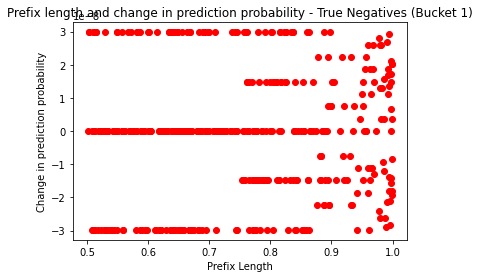

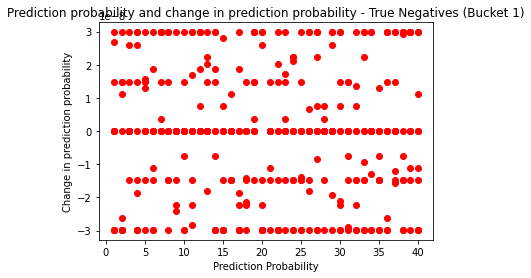

Category 2 of 2. Instance 1 of 400
Category 2 of 2. Instance 2 of 400
Category 2 of 2. Instance 3 of 400
Category 2 of 2. Instance 4 of 400
Category 2 of 2. Instance 5 of 400
Category 2 of 2. Instance 6 of 400
Category 2 of 2. Instance 7 of 400
Category 2 of 2. Instance 8 of 400
Category 2 of 2. Instance 9 of 400
Category 2 of 2. Instance 10 of 400
Category 2 of 2. Instance 11 of 400
Category 2 of 2. Instance 12 of 400
Category 2 of 2. Instance 13 of 400
Category 2 of 2. Instance 14 of 400
Category 2 of 2. Instance 15 of 400
Category 2 of 2. Instance 16 of 400
Category 2 of 2. Instance 17 of 400
Category 2 of 2. Instance 18 of 400
Category 2 of 2. Instance 19 of 400
Category 2 of 2. Instance 20 of 400
Category 2 of 2. Instance 21 of 400
Category 2 of 2. Instance 22 of 400
Category 2 of 2. Instance 23 of 400
Category 2 of 2. Instance 24 of 400
Category 2 of 2. Instance 25 of 400
Category 2 of 2. Instance 26 of 400
Category 2 of 2. Instance 27 of 400
Category 2 of 2. Instance 28 of 400
C

Category 2 of 2. Instance 226 of 400
Category 2 of 2. Instance 227 of 400
Category 2 of 2. Instance 228 of 400
Category 2 of 2. Instance 229 of 400
Category 2 of 2. Instance 230 of 400
Category 2 of 2. Instance 231 of 400
Category 2 of 2. Instance 232 of 400
Category 2 of 2. Instance 233 of 400
Category 2 of 2. Instance 234 of 400
Category 2 of 2. Instance 235 of 400
Category 2 of 2. Instance 236 of 400
Category 2 of 2. Instance 237 of 400
Category 2 of 2. Instance 238 of 400
Category 2 of 2. Instance 239 of 400
Category 2 of 2. Instance 240 of 400
Category 2 of 2. Instance 241 of 400
Category 2 of 2. Instance 242 of 400
Category 2 of 2. Instance 243 of 400
Category 2 of 2. Instance 244 of 400
Category 2 of 2. Instance 245 of 400
Category 2 of 2. Instance 246 of 400
Category 2 of 2. Instance 247 of 400
Category 2 of 2. Instance 248 of 400
Category 2 of 2. Instance 249 of 400
Category 2 of 2. Instance 250 of 400
Category 2 of 2. Instance 251 of 400
Category 2 of 2. Instance 252 of 400
C

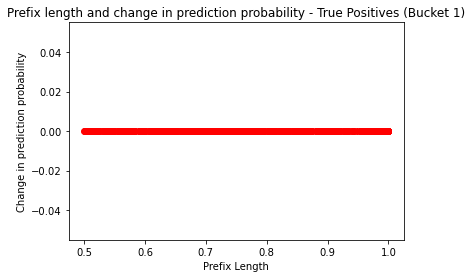

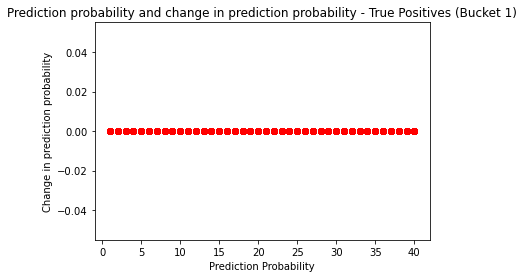

In [10]:
for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))

        all_shap_changes = []
        all_lens = []
        all_probas = []
        all_case_ids = []
        
        pos_shap_changes = []
        pos_probas = []
        pos_nr_events = []
        pos_case_ids = []
                
        neg_shap_changes = []
        neg_probas = []
        neg_nr_events = []
        neg_case_ids = []
            
        for bucket in list(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import data for bucket
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)
            with open (Y_train_path, 'rb') as f:
                train_y = pickle.load(f)
            #with open (X_test_path, 'rb') as f:
            #    dt_test_bucket = pickle.load(f)
            #with open (Y_test_path, 'rb') as f:
            #    test_y = pickle.load(f)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            #fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            #fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            #with open (fn_path, 'rb') as f:
            #    fn_list = pickle.load(f)
            #with open (fp_path, 'rb') as f:
            #    fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            #sample_instances.append(fn_list)
            #sample_instances.append(fp_list)
                    
            tree_explainer = shap.TreeExplainer(cls)
            feat_list = feature_combiner.get_feature_names()
            type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
            max_feat = round(len(feat_list)*0.5)
            #print(max_feat)


            for i in range(len(sample_instances)):
                changes = []
                probas = []
                nr_events = []
                case_ids = []
            
                for j in range(len(sample_instances[i])):
                    print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                    each = sample_instances[i][j]

                    ind = each['predicted']
                    case_ids.append(each['caseID'])
                    p1 = each['proba']
                    probas.append(p1)
                    nr_events.append(each['nr_events'])
                    input_ = each['input']

                    test_x_group = feature_combiner.fit_transform(input_) 
                    #test_x=np.transpose(test_x_group[0])
                    #print(test_x)
                    #print(p1)

                    exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)
                    least_imp = exp[max_feat+1:]
                    features = []

                    for explanation in least_imp:
                        features.extend([feat[0] for feat in explanation])

                    counter = Counter(features).most_common(len(feat_list)-max_feat)

                    rel_feats = [feat[0] for feat in counter]
                    diffs = []
                    alt_x = np.copy(test_x_group)

                    for feat in rel_feats:
                        feat_loc = feat_list.index(feat)
                        alt_x[0][feat_loc] = -1
                        
                    p2 = cls.predict_proba(alt_x)[0][ind]
                    diff = p2-p1
                    #diffs.append(diff)

                    each['shap_fid_change'] = diff#s
                    changes.append(diff)#np.std(diffs))
                    #print("RMSE for instance:", np.std(diffs))
                    
                    if ind == 0:
                        pos_shap_changes.append(diff)#np.std(diffs))
                        pos_probas.append(p1)
                        pos_nr_events.append(each['nr_events'])
                        pos_case_ids.append(each['caseID'])
                    else:
                        neg_shap_changes.append(diff)#np.std(diffs))
                        neg_probas.append(p1)
                        neg_nr_events.append(each['nr_events'])
                        neg_case_ids.append(each['caseID'])

                fig, ax = plt.subplots()
                ax.plot(probas, changes, 'ro', label = "SHAP")
                ax.set_xlabel("Prefix Length")
                ax.set_ylabel("Change in prediction probability")
                #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,1.1, 0.1))
                plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                plt.show()

                fig2, ax2 = plt.subplots()
                ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                ax2.set_xlabel("Prediction Probability")
                ax2.set_ylabel("Change in prediction probability")
                #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,1.1, 0.1))
                plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                plt.show()

                all_shap_changes.extend(changes)
                all_lens.extend(nr_events)
                all_probas.extend(probas)
                all_case_ids.extend(case_ids)

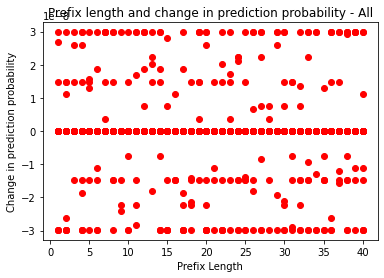

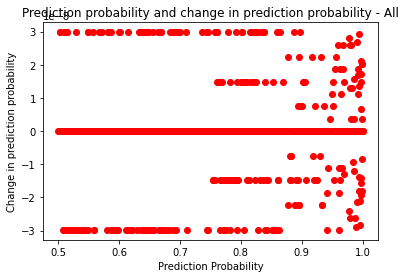

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

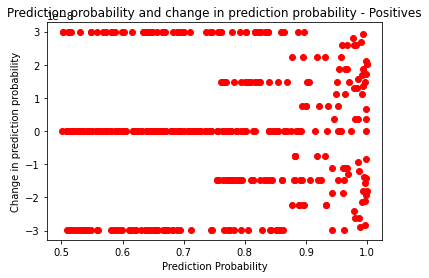

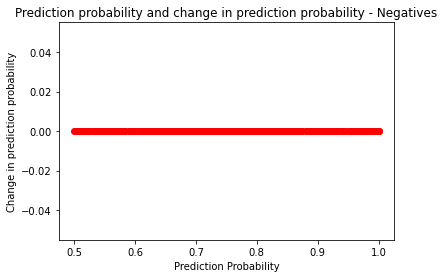

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 1
Category 1 of 2. Instance 1 of 400
Category 1 of 2. Instance 2 of 400
Category 1 of 2. Instance 3 of 400
Category 1 of 2. Instance 4 of 400
Category 1 of 2. Instance 5 of 400
Category 1 of 2. Instance 6 of 400
Category 1 of 2. Instance 7 of 400
Category 1 of 2. Instance 8 of 400
Category 1 of 2. Instance 9 of 400
Category 1 of 2. Instance 10 of 400
Category 1 of 2. Instance 11 of 400
Category 1 of 2. Instance 12 of 400
Category 1 of 2. Instance 13 of 400
Category 1 of 2. Instance 14 of 400
Category 1 of 2. Instance 15 of 400
Category 1 of 2. Instance 16 of 400
Category 1 of 2. Instance 17 of 400
Category 1 of 2. Instance 18 of 400
Category 1 of 2. Instance 19 of 400
Category 1 of 2. Instance 20 of 400
Category 1 of 2. Instance 21 of 400
Category 1 of 2. Instance 22 of 400
Category 1 of 2. Instance 23 of 400
Category 1 of 2. Instance 24 of 400
Category 1 of 2. Instance 25 of 400
Category 1 of 2. Instance 26 of 400
Category 1 of 2. Instance 27 of 400
Category 1 of 2. Instance 28

Category 1 of 2. Instance 226 of 400
Category 1 of 2. Instance 227 of 400
Category 1 of 2. Instance 228 of 400
Category 1 of 2. Instance 229 of 400
Category 1 of 2. Instance 230 of 400
Category 1 of 2. Instance 231 of 400
Category 1 of 2. Instance 232 of 400
Category 1 of 2. Instance 233 of 400
Category 1 of 2. Instance 234 of 400
Category 1 of 2. Instance 235 of 400
Category 1 of 2. Instance 236 of 400
Category 1 of 2. Instance 237 of 400
Category 1 of 2. Instance 238 of 400
Category 1 of 2. Instance 239 of 400
Category 1 of 2. Instance 240 of 400
Category 1 of 2. Instance 241 of 400
Category 1 of 2. Instance 242 of 400
Category 1 of 2. Instance 243 of 400
Category 1 of 2. Instance 244 of 400
Category 1 of 2. Instance 245 of 400
Category 1 of 2. Instance 246 of 400
Category 1 of 2. Instance 247 of 400
Category 1 of 2. Instance 248 of 400
Category 1 of 2. Instance 249 of 400
Category 1 of 2. Instance 250 of 400
Category 1 of 2. Instance 251 of 400
Category 1 of 2. Instance 252 of 400
C

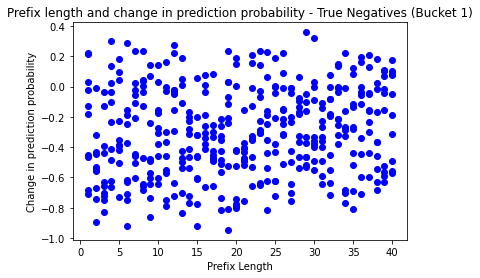

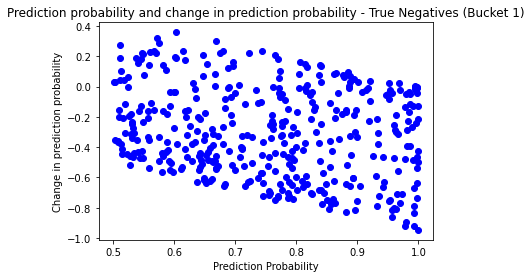

Category 2 of 2. Instance 1 of 400
Category 2 of 2. Instance 2 of 400
Category 2 of 2. Instance 3 of 400
Category 2 of 2. Instance 4 of 400
Category 2 of 2. Instance 5 of 400
Category 2 of 2. Instance 6 of 400
Category 2 of 2. Instance 7 of 400
Category 2 of 2. Instance 8 of 400
Category 2 of 2. Instance 9 of 400
Category 2 of 2. Instance 10 of 400
Category 2 of 2. Instance 11 of 400
Category 2 of 2. Instance 12 of 400
Category 2 of 2. Instance 13 of 400
Category 2 of 2. Instance 14 of 400
Category 2 of 2. Instance 15 of 400
Category 2 of 2. Instance 16 of 400
Category 2 of 2. Instance 17 of 400
Category 2 of 2. Instance 18 of 400
Category 2 of 2. Instance 19 of 400
Category 2 of 2. Instance 20 of 400
Category 2 of 2. Instance 21 of 400
Category 2 of 2. Instance 22 of 400
Category 2 of 2. Instance 23 of 400
Category 2 of 2. Instance 24 of 400
Category 2 of 2. Instance 25 of 400
Category 2 of 2. Instance 26 of 400
Category 2 of 2. Instance 27 of 400
Category 2 of 2. Instance 28 of 400
C

Category 2 of 2. Instance 226 of 400
Category 2 of 2. Instance 227 of 400
Category 2 of 2. Instance 228 of 400
Category 2 of 2. Instance 229 of 400
Category 2 of 2. Instance 230 of 400
Category 2 of 2. Instance 231 of 400
Category 2 of 2. Instance 232 of 400
Category 2 of 2. Instance 233 of 400
Category 2 of 2. Instance 234 of 400
Category 2 of 2. Instance 235 of 400
Category 2 of 2. Instance 236 of 400
Category 2 of 2. Instance 237 of 400
Category 2 of 2. Instance 238 of 400
Category 2 of 2. Instance 239 of 400
Category 2 of 2. Instance 240 of 400
Category 2 of 2. Instance 241 of 400
Category 2 of 2. Instance 242 of 400
Category 2 of 2. Instance 243 of 400
Category 2 of 2. Instance 244 of 400
Category 2 of 2. Instance 245 of 400
Category 2 of 2. Instance 246 of 400
Category 2 of 2. Instance 247 of 400
Category 2 of 2. Instance 248 of 400
Category 2 of 2. Instance 249 of 400
Category 2 of 2. Instance 250 of 400
Category 2 of 2. Instance 251 of 400
Category 2 of 2. Instance 252 of 400
C

In [ ]:
for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = range(len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))]))
        
        all_lime_changes = []
        all_lens = []
        all_probas = []
        all_case_ids = []
        
        pos_lime_changes = []
        pos_probas = []
        pos_nr_events = []
        pos_case_ids = []
                
        neg_lime_changes = []
        neg_probas = []
        neg_nr_events = []
        neg_case_ids = []

        for bucket in list(num_buckets):
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import data for bucket
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)
            with open (Y_train_path, 'rb') as f:
                train_y = pickle.load(f)
            #with open (X_test_path, 'rb') as f:
            #    dt_test_bucket = pickle.load(f)
            #with open (Y_test_path, 'rb') as f:
            #    test_y = pickle.load(f)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            #fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            #fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            #with open (fn_path, 'rb') as f:
            #    fn_list = pickle.load(f)
            #with open (fp_path, 'rb') as f:
            #    fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            #sample_instances.append(fn_list)
            #sample_instances.append(fp_list)

            #get the training data as a matrix
            trainingdata = feature_combiner.fit_transform(dt_train_bucket);
            #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

            feat_list = feature_combiner.get_feature_names()
            max_feat = round(len(feat_list)*0.5)
            class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
            lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                    class_names=class_names, discretize_continuous=True)
            type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

            for i in list(range(len(sample_instances))):
                changes = []
                probas = []
                nr_events = []
                case_ids = []

                for j in list(range(len(sample_instances[i]))):
                    print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                    each = sample_instances[i][j]

                    ind = each['predicted']
                    case_ids.append(each['caseID'])
                    p1 = each['proba']
                    probas.append(p1)
                    #print("proba:", p1)
                    nr_events.append(each['nr_events'])
                    input_ = each['input']

                    test_x_group = feature_combiner.fit_transform(input_) 
                    test_x=np.transpose(test_x_group[0])
                    #print(test_x)
                    #print(p1)

                    explanations = []
                    for iteration in range(exp_iter):
                        lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = len(feat_list))
                        explanation = lime_exp.as_list()
                        explanations.extend(explanation)

                    features = []
                    for explanation in explanations[max_feat+1:]:
                        features.append(explanation[0])
                    
                    counter = Counter(features)
                    check_dup = []
                    for feat in feat_list:
                        for feature in counter:
                            if feat in feature:
                                check_dup.append(feat)

                    dup_counter = Counter(check_dup)
                    duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]
                    
                    for each in duplicated:
                        dpls = []
                        vals = []
                        for feat in counter.keys():
                            if each in feat:
                                dpls.append(feat)
                                vals.append(counter[feat])
                        keepval = vals.index(max(vals))
                        for i in range(len(dpls)):
                            if i != keepval:
                                del counter[dpls[i]]

                    rel_feat = counter.most_common(len(feat_list)-max_feat)
                    
                    diffs = []
                    alt_x = np.copy(test_x_group)

                    for item in rel_feat:
                        feat = item[0]
                        #print(item)
                        #print(feat)
                        for n in range(len(feat_list)):
                            if feat_list[n] in feat:
                                new_val = -1
                                alt_x[0][n] = new_val
                         
                        p2 = cls.predict_proba(alt_x)[0][ind]
                        diff = p2-p1
                        #diffs.append(diff)
                        
                    changes.append(diff)#np.std(diffs))
                    each['lime_fid_change'] = diff#s
                    #print("RMSE for instance:", np.std(diffs))

                    
                    if ind == 0:
                        pos_lime_changes.append(diff)#np.std(diffs))
                        pos_probas.append(p1)
                        pos_nr_events.append(each['nr_events'])
                        pos_case_ids.append(each['caseID'])
                    else:
                        neg_lime_changes.append(diff)#np.std(diffs))
                        neg_probas.append(p1)
                        neg_nr_events.append(each['nr_events'])
                        neg_case_ids.append(each['caseID'])

                fig, ax = plt.subplots()
                ax.plot(nr_events, changes, 'bo', label = "LIME")
                ax.set_xlabel("Prefix Length")
                ax.set_ylabel("Change in prediction probability")
                #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,1.1, 0.1))
                plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                plt.show()

                fig2, ax2 = plt.subplots()
                ax2.plot(probas, changes, 'bo', label = "LIME")
                ax2.set_xlabel("Prediction Probability")
                ax2.set_ylabel("Change in prediction probability")
                #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                #plt.yticks(np.arange(0,1.1, 0.1))
                plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                plt.show()

                all_lime_changes.extend(changes)
                all_lens.extend(nr_events)
                all_probas.extend(probas)
                all_case_ids.extend(case_ids)


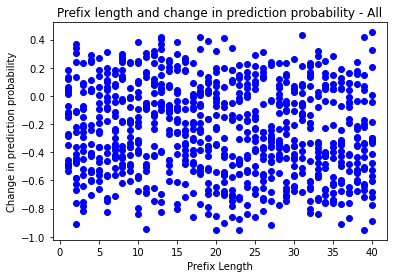

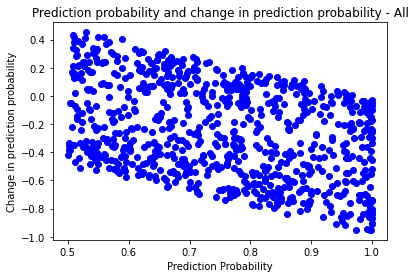

In [14]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

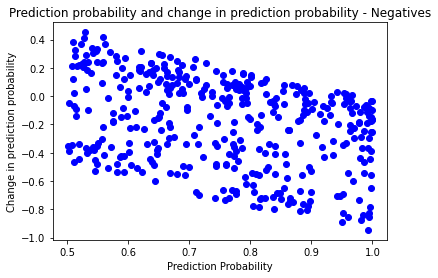

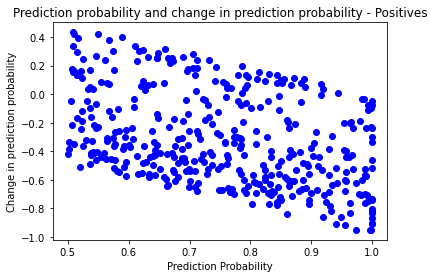

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [16]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

LIME Fidelity Score: -0.2506888641016849 
SHAP Fidelity Score: -5.187757778912782e-10


In [17]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

Positive predictions: 
LIME Fidelity Score: -0.1851158411745564 
SHAP Fidelity Score: -1.0375515557825565e-09
Negative predictions: 
LIME Fidelity Score: -0.31626188702881336 
SHAP Fidelity Score: 0.0


In [18]:
explanation

('agg__Resource_10779.0 <= 0.00', -0.0036552837106026683)

In [19]:
for each in explanation:
    feat = each[0]
    for n in range(len(feat_list)):
        if feat_list[n] in feat:
            print(n, ":", feat_list[n])

TypeError: 'float' object is not subscriptable

In [ ]:
feat_list